# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

The fraction of the total variance for k = 1 is 16.40%
The fraction of the total variance for k = 2 is 29.73%
The fraction of the total variance for k = 3 is 39.90%
The fraction of the total variance for k = 4 is 46.96%
The fraction of the total variance for k = 5 is 50.83%
The fraction of the total variance for k = 10 is 65.22%
The fraction of the total variance for k = 20 is 80.90%
The fraction of the total variance for k = 30 is 89.85%
The fraction of the total variance for k = 40 is 95.09%
The fraction of the total variance for k = 50 is 98.21%


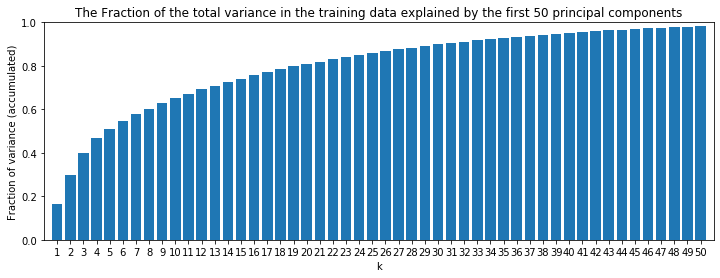

In [5]:
def P1():
    ### STUDENT START ###
    #Define instance of PCA() class
    pc_all = PCA()
    # Fit the training data
    pc_all.fit(train_data)
    K = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    Total_K = 50
    #Calculate partial variance for all possible numbers of k principal components (k=50)
    partial_variance = pc_all.explained_variance_ratio_[:Total_K].cumsum()
    #Print the fraction of total variance fo given values in K 
    for k in K:
        variance = 100 * partial_variance[k-1]
        print('The fraction of the total variance for k = {0} is {1:.2f}%'.format(k,variance))
    #Lineplot of fraction of total variance vs. number of principal components, 
    #for all possible numbers of principal components
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(1,51), partial_variance, align="center")
    plt.title('The Fraction of the total variance in the training data explained'\
              ' by the first 50 principal components')
    plt.xticks(np.arange(1,51), np.array([str(i) for i in np.arange(1,51)]))
    plt.xlabel('k')
    plt.ylabel('Fraction of variance (accumulated)')
    plt.axis([0, 51, 0, 1])
    plt.show()   
    
    ### STUDENT END ###

P1()


### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

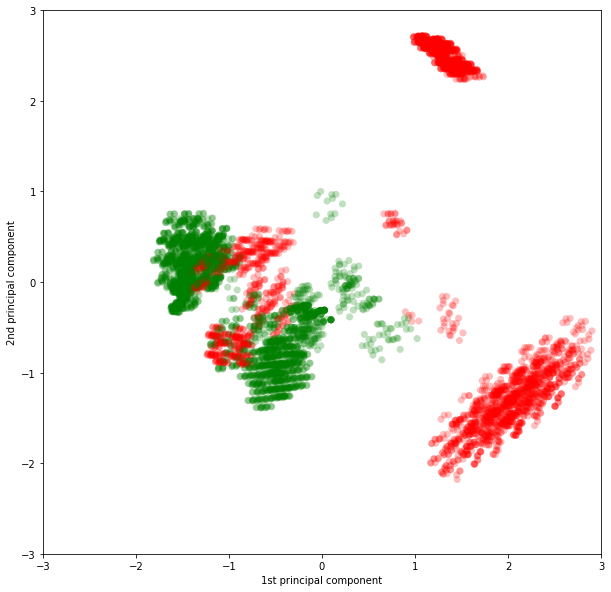

In [6]:
def P2():

    ### STUDENT START ###
    # Define instance of PCA for 2 dimensions
    pc_2 = PCA(n_components=2)
    # Fit the training data
    train_pc = pc_2.fit_transform(train_data)
    #Draw the square scatterplot
    plt.figure(figsize=(10, 10))
    #Choose Red color for poisonous examples and green for non-pisonous examples
    colors = np.where(train_labels == 1, 'red', 'green')
    plt.scatter(train_pc[:,0], train_pc[:,1], c = colors, alpha = 0.25, s = 50, edgecolor='')
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    # The following calculations are to find out min and max to be applied to x and y axis 
    # as square scatterplot has to be drawn
    x_min = np.floor(train_pc[:,0].min())
    y_min = np.floor(train_pc[:,1].min())
    x_max = np.ceil(train_pc[:,0].max())
    y_max = np.ceil(train_pc[:,1].max())
    plot_min = min(x_min,y_min)
    plot_max = max(x_max,y_max)
    plt.xlim([plot_min,plot_max])
    #plt.xlim([np.floor(train_pc[:,0].min()), np.ceil(train_pc[:,0].max())])
    plt.ylim([plot_min,plot_max])
    #plt.ylim([np.floor(train_pc[:,1].min()), np.ceil(train_pc[:,1].max())])
    ### STUDENT END ###

P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

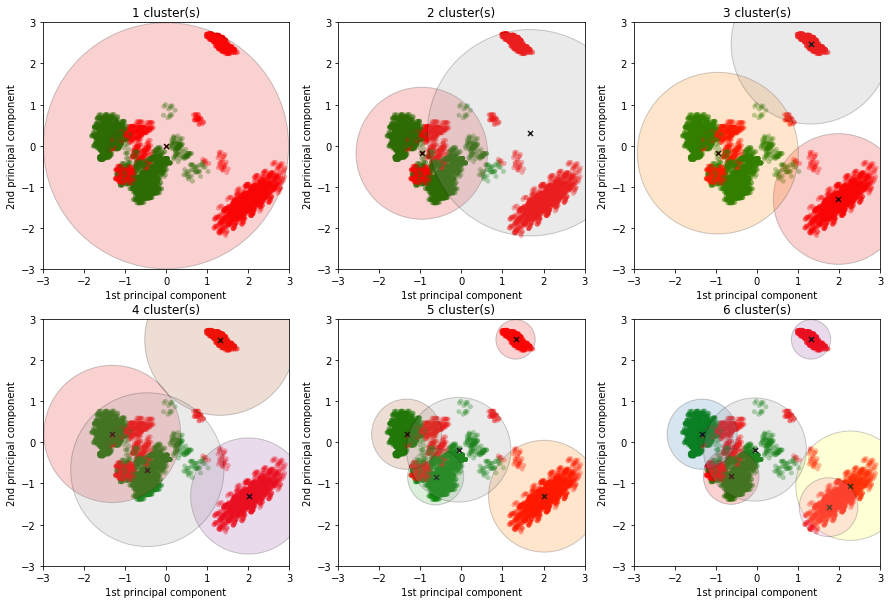

In [17]:
def P3():

    ### STUDENT START ###
    # Define instance of PCA for 2 dimensions
    pc_2 = PCA(n_components=2)
    # Fit the training data
    train_pc = pc_2.fit_transform(train_data)
    #Define number of clusters 
    N = 6
    # Calulate total size of the figure as per given N (3 figures in each row)
    plt.figure(figsize = (5*min(N,3), 5*int(np.ceil(N/3.))))
    # Run the KMeans for cluster value ranging from 1 to N
    for n in range(1,N+1):
        km = KMeans(n_clusters=n, init='k-means++', max_iter=1000)
        clstrs = km.fit (train_pc)
        # Define Colors for Circles 
        Circle_Colors = plt.cm.Set1(np.linspace(0, 1, n))
        # Choose Red color for poisonous examples and green for non-pisonous examples
        colors = np.where(train_labels == 1, 'red', 'green')
        ax = plt.subplot(int(np.ceil(N/3.)), int(np.where(N/3>=1,3,n)), n)
        plt.scatter (train_pc[:,0], train_pc[:,1], c = colors, alpha = 0.33, s=25,edgecolor='')
        # Draw circles and mark the centroid
        for j in range(n):
            radius = metrics.euclidean_distances([clstrs.cluster_centers_[j,:]],train_pc[clstrs.labels_==j]).max()
            circle=plt.Circle(tuple(clstrs.cluster_centers_[j,:]), radius, clip_on=True)
            circle.set_facecolor(Circle_Colors[j,:])
            circle.set_alpha(0.2)
            circle.set_edgecolor('black')
            plt.gca().add_artist(circle)
        plt.scatter (clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1],marker = 'x', c = 'black', s = 25)
        plt.title (str(n) + " cluster(s)")
        plt.xlabel("1st principal component")
        plt.ylabel("2nd principal component")
        plt.xlim([np.floor(train_pc.min()), np.ceil(train_pc.max())])
        plt.ylim([np.floor(train_pc.min()), np.ceil(train_pc.max())])   
    
    ### STUDENT END ###

P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/Users/prasadvalavade/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Log scale: values of z <= 0 have been

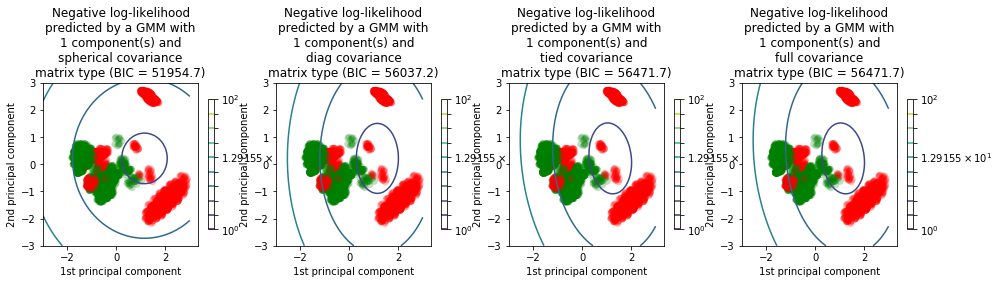

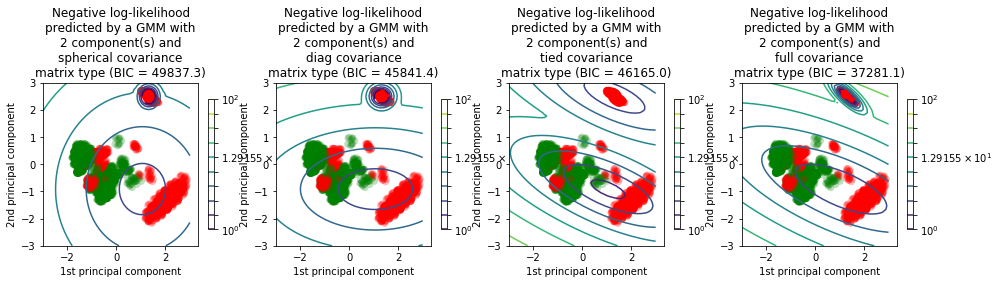

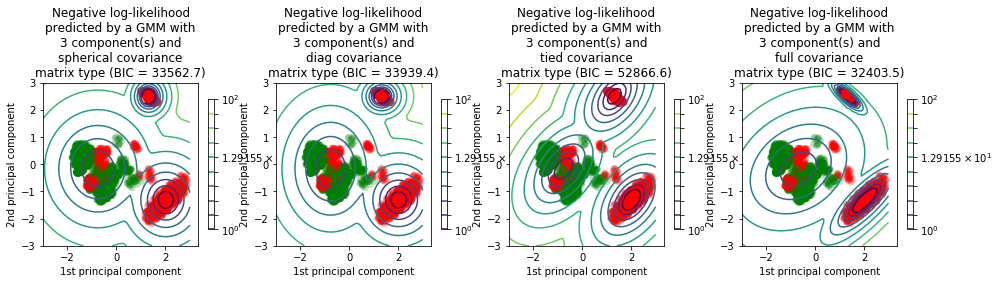

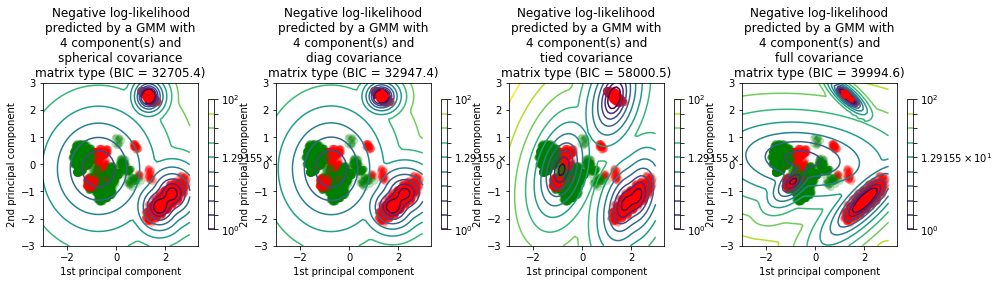

In [34]:
def P4():

    ### STUDENT START ###
    pc_2 = PCA(n_components=2)
    train_pc = pc_2.fit_transform(train_data)
    covar = ['spherical', 'diag', 'tied', 'full']
    for comp in range(1,5):
        if not isinstance(covar, list):
                temp = []
                temp.append(covar)
                covar = temp
            # Total width of the figure proportional to the types of covariance matrices
        plt.figure(figsize = (4*len(covar), 3))
        for i,c in enumerate(covar):
            # Plot a (sub)figure for each type of covariance matrix
            gm = GaussianMixture(n_components=comp, covariance_type=c)
            # Fit the GM model to the positive examples
            gm.fit(train_pc[train_labels==1])
            # Display predicted scores by the model as a contour plot
            x = np.linspace(-3.0, 3.0)
            y = np.linspace(-3.0, 3.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)
            ax = plt.subplot(1, len(covar), i+1)
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=100.0),
                             levels=np.logspace(0, 2, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            # Choose Red color for poisonous examples and green for non-pisonous examples 
            colors = np.where(train_labels == 1, 'red', 'green')
            plt.scatter(train_pc[:,0], train_pc[:,1], c = colors, alpha = 0.25, s = 50,
                        edgecolor='')
            # Include information about the BIC in each plot's title
            plt.title('Negative log-likelihood\npredicted by a GMM with\n{0} component(s) and'
                      '\n{1} covariance\nmatrix type (BIC = {2:.1f})'.\
                      format(comp, c, gm.bic(train_pc)))
            plt.xlabel("1st principal component")
            plt.ylabel("2nd principal component")
            plt.axis('tight')
    ### STUDENT END ###

P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [40]:
def P5():

    ### STUDENT START ###
    pc_2 = PCA(n_components=2)
    train_pc = pc_2.fit_transform(train_data)
    test_pc = pc_2.transform(test_data)
    # The model for positive examples
    gm_pos = GaussianMixture(n_components=4, covariance_type='full',random_state=12345)
    gm_pos.fit(train_pc[train_labels==1])
    # The model for negative examples
    gm_neg = GaussianMixture(n_components=4, covariance_type='full',random_state=12345)
    gm_neg.fit(train_pc[train_labels==0])
    # Finding probabilities
    logprob_pos = gm_pos.score_samples(test_pc)
    logprob_neg = gm_neg.score_samples(test_pc)
    predictions = np.where(logprob_pos >= logprob_neg, 1, 0)
    print('THE ACCURACY IS {0:.2f}%'.format(100*metrics.accuracy_score(test_labels, predictions)))
    CM = metrics.confusion_matrix(test_labels, predictions)
    mushroom_type = [c.rjust(5) for c in map(str, np.unique(train_labels))]
    print("\nCONFUSION MATRIX")
    print("\n|    |{}|{}|".format(*mushroom_type))
    print('------------------')
    table = []
    for i,j in enumerate(np.unique(train_labels)):
        table.append([j, CM[i,0], CM[i,1]])
    for i in table:
        print("|{:4}|{:5}|{:5}|".format(*i))
    ### STUDENT END ###

P5()

THE ACCURACY IS 95.02%

CONFUSION MATRIX

|    |    0|    1|
------------------
|   0|  397|    9|
|   1|   47|  671|


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [61]:
def P6():

    ### STUDENT START ###
    F, C = np.meshgrid(np.arange(1, 25), np.arange(1, 26))
    cond_spherical = 2*(F+1)*C <= 50
    cond_diag = 4*F*C <= 50
    cond_tied = F*(F+2*C+1) <= 50
    cond_full = F*(F+3)*C <= 50
    conditions = [cond_spherical, cond_diag, cond_tied, cond_full]
    covar = ['spherical', 'diag', 'tied', 'full']
    best_accuracy = 0.0
    best_covar_type = None
    best_F = None
    best_C = None
    # An empty array to store each new case
    cases = np.empty((0,4))
    for i,cond in enumerate(conditions):
        # For the 4 possible types of covariance matrix
        for f,c in np.column_stack((F[cond],C[cond])):
            # For all values of F and C that satisfy the condition (num_parameters <= 50)
            # Use F features (principal components)
            pc_F = PCA(n_components=f)
            train_pc = pc_F.fit_transform(train_data)
            test_pc = pc_F.transform(test_data)
            # Create 2 GMMs, one per class, with C mixture components
            gm_pos = GaussianMixture(n_components=c, covariance_type=covar[i], random_state=12345)
            gm_neg = GaussianMixture(n_components=c, covariance_type=covar[i], random_state=12345)
            # Fit each GMM to the corresponding examples
            gm_pos.fit(train_pc[train_labels==1])
            gm_neg.fit(train_pc[train_labels==0])
            # Compute the log probabilities under each model
            logprob_pos = gm_pos.score_samples(test_pc)
            logprob_neg = gm_neg.score_samples(test_pc)
            # Predict the type of mushroom after comparing probabilities
            predictions = np.where(logprob_pos >= logprob_neg, 1, 0)
            # Calculate the accuracy
            acc = metrics.accuracy_score(test_labels, predictions)
            # Include new case
            cases = np.append(cases, np.array([[f, c, i, acc]]), axis=0)
            if acc > best_accuracy:
                best_accuracy = acc
                best_F = f
                best_C = c
                best_covar_type = covar[i]
    # Final result
    if best_covar_type == 'spherical':
        num_parameters = 2*(best_F+1)*best_C
    elif best_covar_type == 'diag':
        num_parameters = 4*best_F*best_C
    elif best_covar_type == 'tied':
        num_parameters = best_F*(best_F+2*best_C+1)
    elif best_covar_type == 'full':
        num_parameters = best_F*(best_F+3)*best_C
    print('THE MODEL that gives the best accuracy with no more than 50 parameters :\n')
    print('\tPCA COMPONENTS: {0}'.format(best_F))
    print('\tThe NO OF GAUSSIAN MIXTURE COMPONENTS: {0}'.format(best_C))
    print('\tCOVARIANCE: {0}'.format(best_covar_type.upper()))
    print('\tEXACT GMM PARAMETERS: {0}'.format(num_parameters))
    print('\tACCURACY: {0:.2f}%\n'.\
        format(100*best_accuracy))
    # Sort all cases (in descending order of the accuracy)
    cases = cases[cases[:, 3].argsort()[::-1], :]
    # Draw a table with all of them
    Results = [' Case', '  F', '  C', ' Covariance matrix type', ' Accuracy']
    print("\n|{}|{}|{}|{}|{}|".format(*Results))
    print('-------------------------------------------------')
    table = []
    for i,case in enumerate(cases):
        table.append([i+1, int(case[0]), int(case[1]), covar[int(case[2])].rjust(23), case[3]])
    for row in table:
        print("|{:5}|{:3}|{:3}|{}|{:9.4f}|".format(*row))
    ### STUDENT END ###

P6()

THE MODEL that gives the best accuracy with no more than 50 parameters :

	PCA COMPONENTS: 11
	The NO OF GAUSSIAN MIXTURE COMPONENTS: 2
	COVARIANCE: SPHERICAL
	EXACT GMM PARAMETERS: 48
	ACCURACY: 97.42%


| Case|  F|  C| Covariance matrix type| Accuracy|
-------------------------------------------------
|    1| 11|  2|              spherical|   0.9742|
|    2|  6|  2|                   diag|   0.9733|
|    3|  7|  3|              spherical|   0.9733|
|    4|  7|  2|              spherical|   0.9715|
|    5|  4|  3|                   tied|   0.9698|
|    6|  5|  2|                   tied|   0.9689|
|    7|  8|  2|              spherical|   0.9689|
|    8| 10|  2|              spherical|   0.9689|
|    9|  6|  3|              spherical|   0.9680|
|   10|  9|  2|              spherical|   0.9662|
|   11|  5|  3|              spherical|   0.9662|
|   12|  5|  4|              spherical|   0.9635|
|   13|  6|  2|              spherical|   0.9600|
|   14|  3|  4|              spherical|   0.9